# Lunar Lander with Deep Q-Learning


This notebook implements the [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) from OpenAI's Gym with Pytorch. The goal is to land the lander safely in the landing pad.

**Introduction of the project:**

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Acknowledgement:**<br>
- The lunar lander environment set up comes from [OpenAI' Gym](https://gym.openai.com/).
- The `rl_glue` set up and the idea of experimence replay come from the [Reinforcement Learning Specialization from Coursera](https://www.coursera.org/specializations/reinforcement-learning).


# Section 1: Training

## 1. Import Packages


In [1]:
# Basic packages
import os

import shutil

from collections import deque

from copy import deepcopy

from tqdm.auto import tqdm

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Lunar lander and RL-GLUE packages
from rl_glue import RLGlue
from environment import BaseEnvironment

from lunar_lander import LunarLanderEnvironment

from agent import BaseAgent

from plot_script import plot_result, draw_neural_net

# Pytorch packages
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

# Gym packages
import gym
from gym import wrappers
from time import time

/home/robert/.miniconda/envs/bromley/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Build the neural network

### 2.1 Build the network

In [2]:
class RLModel(nn.Module):
    
    def __init__(self, network_arch):
        
        super().__init__()
        self.num_states = network_arch['num_states']
        self.hidden_units = network_arch['num_hidden_units']
        self.num_actions = network_arch['num_actions']
        
        # The hidden layer
        self.fc1 = nn.Linear(in_features = self.num_states, out_features = self.hidden_units)
        
        # The output layer
        self.fc2 = nn.Linear(in_features = self.hidden_units, out_features = self.num_actions)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        
        # No activation func, output should be a tensor(batch, num_actions)
        out = self.fc2(x)
        
        return out


### 2.2 Instantiate the model

Create a model with the following archiecture:
- Number of input units (states): 8
- Number of hidden units: 20
- Number of output units (actions): 3

In [3]:
# network_arch = {
#     'num_states' : 8,
#     'num_hidden_units': 20,
#     'num_actions':3
    
# }

# model = RLModel(network_arch)

# model


Visualize the neural network:

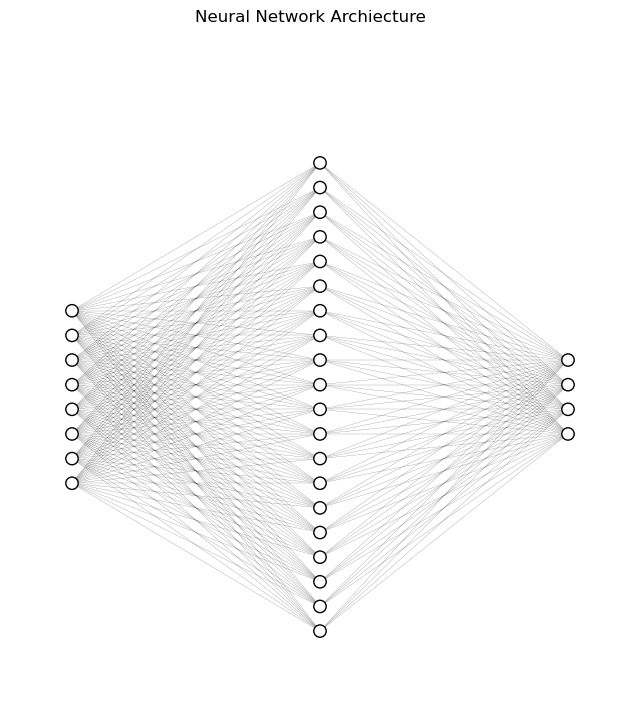

In [4]:
fig = plt.figure(figsize = (8,8))
fig.suptitle('Neural Network Archiecture')
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [8, 20, 4])


## 3. Define loss and optimizer

### 3.1 Optimizer

Here we use Adam optimization.

In [5]:
# Set the learning rate
learning_rate = 0.001

# We will instantiate the optimizer in the agent class.
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = [0.99, 0.999], eps = 1e-04)

### 3.2 Loss

In [6]:
criterion = nn.MSELoss()

## 4. Create the buffer

Create a buffer to implement experience replay. 

In [7]:
class Buffer:
    
    def __init__(self, batch_size, buffer_size, seed):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.rand_generator = np.random.RandomState(seed)
        
        self.buffer = []
        
        
    def append(self, state, action, terminal, reward, next_state):
        """
        Append the next experience.
        
        Args:
            state: the state (torch tensor).
            action: the action (integer).
            terminal: 1 if the next state is the terminal, 0 otherwise.
        
        """
        # delete the first experience if the size is reaching the maximum
        if len(self.buffer) == self.buffer_size:
            del self.buffer[0]
            
        self.buffer.append((torch.tensor(state), torch.tensor(action), torch.tensor(terminal), torch.tensor(reward).float(), torch.tensor(next_state)))
        
    def sample(self):
        """
        Sample from the buffer and return the virtual experience.
        
        Args:
            None
        Returns:
            A list of transition tuples (state, action, terminal, reward, next_state), list length: batch_size
        """
        
        indexs = self.rand_generator.choice(len(self.buffer), size = self.batch_size)
        
        transitions = [self.buffer[idx] for idx in indexs]
        
        return transitions
       
    def get_buffer(self):
        """
        Return the current buffer
        """
        return self.buffer
        
        

## 5. Create the agent

### 5.1 Softmax policy

The probability of selecting each action:

$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$

Where:<br>
$Q(s, a)$: The action value.<br>
$tau$: The temperature parameter.

In [8]:
def softmax(action_values, tau = 1.0):
    
    """
    Args:
        action_values: A torch tensor (2d) of size (batch_size, num_actions).
        tau: Tempearture parameter.
    
    Returns:
        probs: A torch tensor of size (batch_size, num_actions). The value represents the probability of select 
        that action.
    """
    
    max_action_value = torch.max(action_values, axis = 1, keepdim = True)[0]/tau
    action_values = action_values/tau
    
    preference = action_values - max_action_value
    
    exp_action = torch.exp(preference)
    sum_exp_action = torch.sum(exp_action, axis = 1).view(-1,1)


    probs = exp_action/sum_exp_action

    
    return probs



### 5.2 Neural network training function

Create a function to perform one step update: Calculate the TD-error, and do the backpropagation once. We can choose the reinforcement learning algorithms to train the agent. By default, we are using the Q-Learning.

In [9]:
def train_network(experiences, model, current_model, optimizer, criterion, discount, tau):
    
    """
    Calculate the TD-error and update the network
    
    """
    optimizer.zero_grad()
    
    states, actions, terminals, rewards, next_states = map(list, zip(*experiences))
    
    
#     print(next_states)
    q_next = current_model(Variable(torch.stack(next_states))).squeeze()
    probs = softmax(q_next, tau)

    # calculate the maximum action value of next states
#     expected_q_next = (1-torch.stack(terminals)) * (torch.sum(probs * q_next , axis = 1))
    max_q_next = (1-torch.stack(terminals)) * (torch.max(q_next , axis = 1)[0])
    # calculate the targets
    
    rewards = torch.stack(rewards).float()
#     targets = Variable(rewards + (discount * expected_q_next)).float()
    targets = Variable(rewards + (discount * max_q_next)).float()
    
    # calculate the outputs from the previous states (batch_size, num_actions)
    outputs = model(Variable(torch.stack(states).float())).squeeze()
    

    actions = torch.stack(actions).view(-1,1)
    
    outputs = torch.gather(outputs, 1, actions).squeeze()
    
    # the loss
    loss = criterion(outputs, targets)
    
    loss.backward()
    
    # update
    optimizer.step()

### 5.3 Create the agent

Create the agent class.


In [10]:
import pdb

class Agent(BaseAgent):
    
    def __init__(self):
        self.name = 'Lunar Lander Expected Sarsa Agent'
        
    def agent_init(self, agent_config):
        
        """
        Called when the experiment first starts.
        Args:
            agent_config: Python dict contains:
                        {
                        network_arch: dict,
                        batch_size: integer,
                        buffer_size: integer,
                        gamma: float,
                        learning_rate: float,
                        tau: float,
                        seed:integer,
                        num_replay_updates: float
                        
                        
                        }
        
        """
        # The model
        self.model = RLModel(agent_config['network_arch'])
        # The replay buffer
        self.buffer = Buffer(agent_config['batch_size'],
                            agent_config['buffer_size'],
                            agent_config['seed'])
        # The optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                          lr = agent_config['learning_rate'], 
                                          betas = [0.99,0.999], 
                                          eps = 1e-04)
        # The loss
        self.criterion = nn.MSELoss()
        
        self.batch_size = agent_config['batch_size']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        self.num_replay = agent_config['num_replay_updates']
        self.num_actions = agent_config['network_arch']['num_actions']
        # random number generator
        self.rand_generator = np.random.RandomState(agent_config['seed'])
        
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0
        
    def policy(self, state):
        
        """
        Select the action given a single state.
        
        """
        # compute action values states:(1, state_dim)
        q_values = self.model(state)

        # compute the probs of each action (1, num_actions)
        probs = softmax(q_values.data, self.tau)
        probs = np.array(probs)
        probs /= probs.sum()

        # select action
        action = self.rand_generator.choice(self.num_actions, 1, p = probs.squeeze())
        
        return action
    
    
    def agent_start(self, state):
        """
        Called when the experiments starts, after the env starts.
        
        Args:
            state: pytorch tensor.
            
        Returns:
            action: The first action.
        """
        
        self.sum_rewards = 0
        self.episode_steps = 0

        #original:
        #state = torch.tensor([state]).view(1, -1)
        #new:
        state = torch.from_numpy(state[0]).view(1,-1)

        action = self.policy(state)
        
        self.last_state = state
        self.last_action = action.item()
        
        return self.last_action
    
    def agent_step(self, reward, state):
        
        """
        The agent takes one step.
        
        Args:
            reward: The reward the agent received, float.
            state: The next state the agent received, Numpy array.
            
        Returns:
            action: The action the agent is taking, integer.
        
        """
        ### Add another step and reward
        self.episode_steps += 1
        self.sum_rewards += reward
        
        ### Select action
        state = torch.from_numpy(state).view(1,-1)
        
        action = self.policy(state)
        
        ### Append new experience to the buffer
        self.buffer.append(self.last_state, self.last_action, 0, reward, state)
        
        ### Replay steps:
        # replay only if the buffer size is large enough
        if len(self.buffer.get_buffer()) >= self.batch_size:
            # copy the current network
            current_model = deepcopy(self.model)
            
            # replay steps:
            for i in range(self.num_replay):
                
                # sample experiences from the buffer
                experiences = self.buffer.sample()
                
                # train the network
                train_network(experiences, self.model, current_model, self.optimizer, self.criterion, self.discount, self.tau)
                
        ### Update the last state and action
        self.last_state = state
        self.last_action = action.item()
        
        return self.last_action
    
    def agent_end(self, reward):
        
        """
        Called when the agent terminates.
        
        Args:
            reward: The reward the agent received for the termination.
        
        """
        self.episode_steps += 1
        self.sum_rewards += reward
        
        ### Find the final state
        state = torch.zeros_like(self.last_state)
        
        ### Append new experience to the buffer
        self.buffer.append(self.last_state, self.last_action, 1, reward, state)
        
        
        ### Replay steps:
        # replay only if the buffer size is large enough
        if len(self.buffer.get_buffer()) >= self.batch_size:
            # copy the current network
            current_model = deepcopy(self.model)
            
            # replay steps:
            for i in range(self.num_replay):
                
                # sample experiences from the buffer
                experiences = self.buffer.sample()
                
                # train the network
                train_network(experiences, self.model, current_model, self.optimizer, self.criterion, self.discount, self.tau)

        ### Save the model at each episode
        
#         torch.save(self.model, 'new_results/current_nodel.pth')
    def agent_message(self, message):
        
        """
        Return the given agent message.
        
        Args:
            message: String 
        
       """
        if message == 'get_sum_reward':
            
            return self.sum_rewards
        else:
            raise Exception('No given message of the agent!')
    

        

## 8. Run experiments



### 8.1 Experiment function

Create a function to run the experiment.

In [11]:
### A func to run the experiment

def run_experiment(environment, agent, environment_configs, agent_configs, experiment_configs, finetune, PATH = 'new_results/current_model_700.pth'):
    
    """
    Run the experiment.
    
    Args:
        envierment: The environment class.
        agent: The agent class.
        environment_configs: environment parameters (Python dict).
        agent_configs agent parameters (Python dict).
        {
        
        
        }

        experiment_configs: experiment parameters (Python dict)
        {'num_runs': Integer. Number of runs of the experiment,
        'num_episodes': Integer. Number of episodes of the experiment,
        'timeout': Integer. Time step limit of the experiment.
        }
        
        finetune: boolean. Finetune or train from scratch.
    Returns:
        agent_sum_reward: Numpy array(num_runs, num_episodes), the sum reward received by the agent.
    
    """
    
    ### Instantiate the RLGlue class
    rl_glue = RLGlue(environment, agent)
    
    ### Save sum of reward
    agent_sum_reward = np.zeros((experiment_configs['num_runs'],experiment_configs['num_episodes']))
    
    ### Loop over runs
    for run in tqdm(range(experiment_configs['num_runs'])):
        
        # Set the random seed for agent and environment
        agent_configs['seed'] = run
        environment_configs['seed'] = run
        
        # Initialize the rl_glue
        rl_glue.rl_init(agent_configs, environment_configs)
        
        # Finetuning
        if finetune:
            
            checkpoint = torch.load(PATH)
            rl_glue.agent.model.load_state_dict(checkpoint['model_state_dict'])

            start_episode = checkpoint['episode'] + 1
            
            print('Finetuning...')
        else:
            start_episode = 0
            print('Training...')
        
        ### Loop over episodes
        for episode in tqdm(range(start_episode, start_episode + experiment_configs['num_episodes'])):
            # Run episode
            rl_glue.rl_episode(experiment_configs['timeout'])
            
            # Get reward
            episode_reward = rl_glue.rl_agent_message('get_sum_reward')
            
            # Save the reward in the array
            agent_sum_reward[run, episode - start_episode] = episode_reward
            
            # Save the model for testing
            if episode == start_episode + experiment_configs['num_episodes'] - 1:
                
                current_model = rl_glue.agent.model
                torch.save({'episode':episode,
                'model_state_dict':current_model.state_dict(),
                            },
                'new_results/current_model_{}.pth'.format(episode+1))
                
            print('Run:{}, episode:{}, reward:{}'.format(run, episode, episode_reward))
            
    return agent_sum_reward
    

### 8.2 Plot functions

Create helper functions to draw the results.

In [12]:
def plot_reward(rewards, title, starting_episode = 0):
    """Plot the reward of each episode.
    """
    
    rewards = np.mean(rewards, axis = 0).squeeze()
    episodes = np.arange(starting_episode, starting_episode + rewards.shape[0], 1)
    
    plt.figure(figsize = (20,10))
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward of each episode')
    plt.plot(episodes, rewards)
    plt.show()
    
    return


def smooth(data, k):
    """
    Smooth the data with moving average.
    
    """
    num_episodes = data.shape[1]
    num_runs = data.shape[0]

    smoothed_data = np.zeros((num_runs, num_episodes))

    for i in range(num_episodes):
        if i < k:
            smoothed_data[:, i] = np.mean(data[:, :i+1], axis = 1)   
        else:
            smoothed_data[:, i] = np.mean(data[:, i-k:i+1], axis = 1)    
        

    return smoothed_data

### 8.3 Train the agent

Define the following hyperparameters:


In [13]:

agent = Agent
environment = LunarLanderEnvironment

environment_configs = {}
agent_configs = {
    'network_arch' : {'num_states':8,
               'num_hidden_units' : 256,
               'num_actions': 4},
    
    'batch_size': 8,
    'buffer_size': 50000,
    'gamma': 0.99,
    'learning_rate': 1e-4,
    'tau':0.01 ,
    'seed':0,
    'num_replay_updates':5
      
}

experiment_configs = {
    'num_runs':1,
    'num_episodes':1000,
    'timeout': 1000
}

PATH = f"new_results/current_model_{experiment_configs['num_episodes']}.pth"

Run the experiment and get the results. Change `finetune` to `False` to train from scratch.

In [ ]:
sum_reward = run_experiment(environment, agent, environment_configs, agent_configs, experiment_configs, finetune = False, PATH=PATH)

  0%|                                                                              | 0/1 [00:00<?, ?it/s]

Training...



  0%|                                                                           | 0/1000 [00:00<?, ?it/s]/home/robert/.miniconda/envs/bromley/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_11501/160181291.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer.append((torch.tensor(state), torch.tensor(action), torch.tensor(terminal), torch.tensor(reward).float(), torch.tensor(next_state)))

  0%|                                                                   | 1/1000 [00:00<11:37,  1.43it/s]

Run:0, episode:0, reward:-375.0644417603265



  0%|▏                                                                  | 2/1000 [00:01<10:52,  1.53it/s]

Run:0, episode:1, reward:-346.4393619667158



  0%|▏                                                                  | 3/1000 [00:01<08:18,  2.00it/s]

Run:0, episode:2, reward:-224.98071949093475



  0%|▎                                                                  | 4/1000 [00:01<07:11,  2.31it/s]

Run:0, episode:3, reward:-86.04918312374512



  0%|▎                                                                  | 5/1000 [00:02<06:46,  2.45it/s]

Run:0, episode:4, reward:-214.25731456342265



  1%|▍                                                                  | 6/1000 [00:02<07:06,  2.33it/s]

Run:0, episode:5, reward:-269.0704843648773



  1%|▍                                                                  | 7/1000 [00:03<09:21,  1.77it/s]

Run:0, episode:6, reward:-626.2829252971967



  1%|▌                                                                  | 8/1000 [00:04<09:34,  1.73it/s]

Run:0, episode:7, reward:-15.877314690181024



  1%|▌                                                                  | 9/1000 [00:04<09:19,  1.77it/s]

Run:0, episode:8, reward:-137.6954510126487



  1%|▋                                                                 | 10/1000 [00:05<08:36,  1.92it/s]

Run:0, episode:9, reward:-10.804655653183772



  1%|▋                                                                 | 11/1000 [00:05<08:07,  2.03it/s]

Run:0, episode:10, reward:-33.92059880251708



  1%|▊                                                                 | 12/1000 [00:06<08:15,  2.00it/s]

Run:0, episode:11, reward:18.460689018297757



  1%|▊                                                                 | 13/1000 [00:06<08:11,  2.01it/s]

Run:0, episode:12, reward:-93.36569777988396



  1%|▉                                                                 | 14/1000 [00:07<09:02,  1.82it/s]

Run:0, episode:13, reward:-190.9685329399415



  2%|▉                                                                 | 15/1000 [00:07<09:06,  1.80it/s]

Run:0, episode:14, reward:-148.57545814559123



  2%|█                                                                 | 16/1000 [00:09<15:00,  1.09it/s]

Run:0, episode:15, reward:-276.6433066340512



  2%|█                                                                 | 17/1000 [00:10<15:09,  1.08it/s]

Run:0, episode:16, reward:51.81684784060758



  2%|█▏                                                                | 18/1000 [00:13<23:28,  1.43s/it]

Run:0, episode:17, reward:-369.46498694690564



  2%|█▎                                                                | 19/1000 [00:13<19:00,  1.16s/it]

Run:0, episode:18, reward:-302.52059116012845



  2%|█▎                                                                | 20/1000 [00:14<18:05,  1.11s/it]

Run:0, episode:19, reward:-317.310717936085



  2%|█▍                                                                | 21/1000 [00:15<16:48,  1.03s/it]

Run:0, episode:20, reward:-202.21410374033485



  2%|█▍                                                                | 22/1000 [00:16<15:49,  1.03it/s]

Run:0, episode:21, reward:-94.66130488088582



  2%|█▌                                                                | 23/1000 [00:17<14:46,  1.10it/s]

Run:0, episode:22, reward:-71.30590773440457



  2%|█▌                                                                | 24/1000 [00:17<13:47,  1.18it/s]

Run:0, episode:23, reward:-78.37406698972833



  2%|█▋                                                                | 25/1000 [00:19<15:16,  1.06it/s]

Run:0, episode:24, reward:-212.6775958729915



  3%|█▋                                                                | 26/1000 [00:20<15:32,  1.04it/s]

Run:0, episode:25, reward:-75.15353565926878



  3%|█▊                                                                | 27/1000 [00:20<15:14,  1.06it/s]

Run:0, episode:26, reward:-88.0477596384096



  3%|█▊                                                                | 28/1000 [00:21<15:36,  1.04it/s]

Run:0, episode:27, reward:-185.96621457554886



  3%|█▉                                                                | 29/1000 [00:22<14:34,  1.11it/s]

Run:0, episode:28, reward:-87.2989011328075



  3%|█▉                                                                | 30/1000 [00:23<15:19,  1.05it/s]

Run:0, episode:29, reward:-218.6681102663369



  3%|██                                                                | 31/1000 [00:24<14:16,  1.13it/s]

Run:0, episode:30, reward:-253.5544160457212



  3%|██                                                                | 32/1000 [00:25<15:02,  1.07it/s]

Run:0, episode:31, reward:-85.42342054325134



  3%|██▏                                                               | 33/1000 [00:26<14:32,  1.11it/s]

Run:0, episode:32, reward:-338.22688141000623



  3%|██▏                                                               | 34/1000 [00:27<14:05,  1.14it/s]

Run:0, episode:33, reward:-93.71721624654103



  4%|██▎                                                               | 35/1000 [00:27<13:39,  1.18it/s]

Run:0, episode:34, reward:-226.04064063651532



  4%|██▍                                                               | 36/1000 [00:28<12:33,  1.28it/s]

Run:0, episode:35, reward:35.5200114869609



  4%|██▍                                                               | 37/1000 [00:29<12:36,  1.27it/s]

Run:0, episode:36, reward:-138.7915664260526



  4%|██▌                                                               | 38/1000 [00:30<12:27,  1.29it/s]

Run:0, episode:37, reward:-291.4219162711355



  4%|██▌                                                               | 39/1000 [00:31<13:44,  1.17it/s]

Run:0, episode:38, reward:-37.4671024538668



  4%|██▋                                                               | 40/1000 [00:32<13:46,  1.16it/s]

Run:0, episode:39, reward:-223.23550895771797



  4%|██▋                                                               | 41/1000 [00:32<13:49,  1.16it/s]

Run:0, episode:40, reward:-276.1374588514043



  4%|██▊                                                               | 42/1000 [00:33<12:30,  1.28it/s]

Run:0, episode:41, reward:-214.17934433756022



  4%|██▊                                                               | 43/1000 [00:34<11:48,  1.35it/s]

Run:0, episode:42, reward:-252.90303457964575



  4%|██▉                                                               | 44/1000 [00:35<12:37,  1.26it/s]

Run:0, episode:43, reward:-4.358548299998077



  4%|██▉                                                               | 45/1000 [00:35<12:39,  1.26it/s]

Run:0, episode:44, reward:-234.48570109525338



  5%|███                                                               | 46/1000 [00:36<13:17,  1.20it/s]

Run:0, episode:45, reward:12.525260385181198



  5%|███                                                               | 47/1000 [00:37<12:00,  1.32it/s]

Run:0, episode:46, reward:-293.98812940708365



  5%|███▏                                                              | 48/1000 [00:37<10:51,  1.46it/s]

Run:0, episode:47, reward:-302.6729357211184



  5%|███▏                                                              | 49/1000 [00:38<10:50,  1.46it/s]

Run:0, episode:48, reward:-239.76106852482087



  5%|███▎                                                              | 50/1000 [00:39<11:21,  1.39it/s]

Run:0, episode:49, reward:-3.2883706706103197



  5%|███▎                                                              | 51/1000 [00:40<11:26,  1.38it/s]

Run:0, episode:50, reward:-280.60179067866176



  5%|███▍                                                              | 52/1000 [00:40<11:31,  1.37it/s]

Run:0, episode:51, reward:-135.9505967066512



  5%|███▍                                                              | 53/1000 [00:41<11:59,  1.32it/s]

Run:0, episode:52, reward:-179.4640837111463



  5%|███▌                                                              | 54/1000 [00:42<12:13,  1.29it/s]

Run:0, episode:53, reward:-242.86971772010787



  6%|███▋                                                              | 55/1000 [00:43<11:25,  1.38it/s]

Run:0, episode:54, reward:-253.47334084498488



  6%|███▋                                                              | 56/1000 [00:44<13:03,  1.20it/s]

Run:0, episode:55, reward:-304.1193694793406



  6%|███▊                                                              | 57/1000 [00:45<16:04,  1.02s/it]

Run:0, episode:56, reward:-380.1089337453866



  6%|███▊                                                              | 58/1000 [00:47<17:53,  1.14s/it]

Run:0, episode:57, reward:-310.856251724543



  6%|███▉                                                              | 59/1000 [00:48<20:37,  1.31s/it]

Run:0, episode:58, reward:0.8320886306862718



  6%|███▉                                                              | 60/1000 [00:49<19:52,  1.27s/it]

Run:0, episode:59, reward:-259.9507549234477



  6%|████                                                              | 61/1000 [00:50<17:40,  1.13s/it]

Run:0, episode:60, reward:-202.30232026460737



  6%|████                                                              | 62/1000 [00:51<16:24,  1.05s/it]

Run:0, episode:61, reward:-289.5718873820357



  6%|████▏                                                             | 63/1000 [00:52<14:11,  1.10it/s]

Run:0, episode:62, reward:-99.74626459887244



  6%|████▏                                                             | 64/1000 [00:53<14:21,  1.09it/s]

Run:0, episode:63, reward:-233.1391417789858



  6%|████▎                                                             | 65/1000 [00:53<13:28,  1.16it/s]

Run:0, episode:64, reward:-386.2051347001767



  7%|████▎                                                             | 66/1000 [00:54<13:29,  1.15it/s]

Run:0, episode:65, reward:-255.16853889441876



  7%|████▍                                                             | 67/1000 [00:55<12:00,  1.30it/s]

Run:0, episode:66, reward:-472.47684085439835



  7%|████▍                                                             | 68/1000 [00:55<11:01,  1.41it/s]

Run:0, episode:67, reward:-154.22294965975397



  7%|████▌                                                             | 69/1000 [00:56<10:49,  1.43it/s]

Run:0, episode:68, reward:-343.2804530217935



  7%|████▌                                                             | 70/1000 [00:57<10:58,  1.41it/s]

Run:0, episode:69, reward:-182.22791389259186



  7%|████▋                                                             | 71/1000 [00:57<10:04,  1.54it/s]

Run:0, episode:70, reward:-252.43564131722104



  7%|████▊                                                             | 72/1000 [00:58<11:36,  1.33it/s]

Run:0, episode:71, reward:-408.2143142074738



  7%|████▊                                                             | 73/1000 [00:59<11:38,  1.33it/s]

Run:0, episode:72, reward:-225.35623051188767



  7%|████▉                                                             | 74/1000 [01:00<11:51,  1.30it/s]

Run:0, episode:73, reward:-247.63367222299527



  8%|████▉                                                             | 75/1000 [01:01<12:07,  1.27it/s]

Run:0, episode:74, reward:-112.21029738345479



  8%|█████                                                             | 76/1000 [01:02<12:38,  1.22it/s]

Run:0, episode:75, reward:-316.9349806679206



  8%|█████                                                             | 77/1000 [01:03<14:04,  1.09it/s]

Run:0, episode:76, reward:-275.28096271223535



  8%|█████▏                                                            | 78/1000 [01:04<14:19,  1.07it/s]

Run:0, episode:77, reward:-134.00319505332612



  8%|█████▏                                                            | 79/1000 [01:05<15:37,  1.02s/it]

Run:0, episode:78, reward:-467.0283012715227



  8%|█████▎                                                            | 80/1000 [01:06<16:22,  1.07s/it]

Run:0, episode:79, reward:-211.64855287445056



  8%|█████▎                                                            | 81/1000 [01:07<16:15,  1.06s/it]

Run:0, episode:80, reward:-191.90420306648252



  8%|█████▍                                                            | 82/1000 [01:08<17:25,  1.14s/it]

Run:0, episode:81, reward:-304.2186085226094



  8%|█████▍                                                            | 83/1000 [01:09<16:45,  1.10s/it]

Run:0, episode:82, reward:-196.18100906815954



  8%|█████▌                                                            | 84/1000 [01:10<15:03,  1.01it/s]

Run:0, episode:83, reward:-160.52942939985581



  8%|█████▌                                                            | 85/1000 [01:11<15:31,  1.02s/it]

Run:0, episode:84, reward:-188.255721771461



  9%|█████▋                                                            | 86/1000 [01:12<14:20,  1.06it/s]

Run:0, episode:85, reward:-121.91640228865222



  9%|█████▋                                                            | 87/1000 [01:13<15:46,  1.04s/it]

Run:0, episode:86, reward:-71.90142584557357



  9%|█████▊                                                            | 88/1000 [01:15<18:41,  1.23s/it]

Run:0, episode:87, reward:-298.43372288719934



  9%|█████▊                                                            | 89/1000 [01:17<21:32,  1.42s/it]

Run:0, episode:88, reward:-302.58067432953237



  9%|█████▉                                                            | 90/1000 [01:18<19:04,  1.26s/it]

Run:0, episode:89, reward:-273.07188251427334



  9%|██████                                                            | 91/1000 [01:19<20:29,  1.35s/it]

Run:0, episode:90, reward:-100.81296296194202



  9%|██████                                                            | 92/1000 [01:20<17:25,  1.15s/it]

Run:0, episode:91, reward:-17.26768234917583



  9%|██████▏                                                           | 93/1000 [01:21<18:01,  1.19s/it]

Run:0, episode:92, reward:-245.77950952317582



  9%|██████▏                                                           | 94/1000 [01:22<17:22,  1.15s/it]

Run:0, episode:93, reward:-312.0563237265389



 10%|██████▎                                                           | 95/1000 [01:23<16:00,  1.06s/it]

Run:0, episode:94, reward:-122.81488820406946



 10%|██████▎                                                           | 96/1000 [01:24<15:59,  1.06s/it]

Run:0, episode:95, reward:-201.41898700559477



 10%|██████▍                                                           | 97/1000 [01:27<22:04,  1.47s/it]

Run:0, episode:96, reward:-264.9837672193993



 10%|██████▍                                                           | 98/1000 [01:28<20:07,  1.34s/it]

Run:0, episode:97, reward:-105.06285857505003



 10%|██████▌                                                           | 99/1000 [01:30<22:53,  1.52s/it]

Run:0, episode:98, reward:-136.85579846834122



 10%|██████▌                                                          | 100/1000 [01:31<20:29,  1.37s/it]

Run:0, episode:99, reward:-161.44418696280795



 10%|██████▌                                                          | 101/1000 [01:32<21:14,  1.42s/it]

Run:0, episode:100, reward:-185.7159603139154



 10%|██████▋                                                          | 102/1000 [01:33<18:59,  1.27s/it]

Run:0, episode:101, reward:-113.13657060291017



 10%|██████▋                                                          | 103/1000 [01:35<21:38,  1.45s/it]

Run:0, episode:102, reward:-244.1953511059481



 10%|██████▊                                                          | 104/1000 [01:37<25:19,  1.70s/it]

Run:0, episode:103, reward:-268.5396874845947



 10%|██████▊                                                          | 105/1000 [01:39<23:33,  1.58s/it]

Run:0, episode:104, reward:-283.19699077655633



 11%|██████▉                                                          | 106/1000 [01:40<23:27,  1.57s/it]

Run:0, episode:105, reward:-126.05868849316836



 11%|██████▉                                                          | 107/1000 [01:41<20:00,  1.34s/it]

Run:0, episode:106, reward:-276.5231551889934



 11%|███████                                                          | 108/1000 [01:42<20:16,  1.36s/it]

Run:0, episode:107, reward:-193.96527734657724



 11%|███████                                                          | 109/1000 [01:43<19:02,  1.28s/it]

Run:0, episode:108, reward:-223.0434926456305



 11%|███████▏                                                         | 110/1000 [01:44<17:11,  1.16s/it]

Run:0, episode:109, reward:-210.4178903086895



 11%|███████▏                                                         | 111/1000 [01:45<15:14,  1.03s/it]

Run:0, episode:110, reward:-119.98474174325533



 11%|███████▎                                                         | 112/1000 [01:46<16:43,  1.13s/it]

Run:0, episode:111, reward:-318.3224384756353



 11%|███████▎                                                         | 113/1000 [01:48<18:04,  1.22s/it]

Run:0, episode:112, reward:-312.43876254101167



 11%|███████▍                                                         | 114/1000 [01:49<15:58,  1.08s/it]

Run:0, episode:113, reward:-48.825879806415195



 12%|███████▍                                                         | 115/1000 [01:50<19:22,  1.31s/it]

Run:0, episode:114, reward:-182.88818503069666



 12%|███████▌                                                         | 116/1000 [01:52<18:36,  1.26s/it]

Run:0, episode:115, reward:-178.33104550563428



 12%|███████▌                                                         | 117/1000 [01:52<15:45,  1.07s/it]

Run:0, episode:116, reward:-213.15914795900565



 12%|███████▋                                                         | 118/1000 [01:53<14:36,  1.01it/s]

Run:0, episode:117, reward:-85.55191592879063



 12%|███████▋                                                         | 119/1000 [01:54<14:09,  1.04it/s]

Run:0, episode:118, reward:-152.7405957246435



 12%|███████▊                                                         | 120/1000 [01:55<13:50,  1.06it/s]

Run:0, episode:119, reward:-37.39259439576931



 12%|███████▊                                                         | 121/1000 [01:56<14:59,  1.02s/it]

Run:0, episode:120, reward:-41.38126044252283



 12%|███████▉                                                         | 122/1000 [01:57<13:18,  1.10it/s]

Run:0, episode:121, reward:-140.64008478686245



 12%|███████▉                                                         | 123/1000 [01:58<14:18,  1.02it/s]

Run:0, episode:122, reward:-333.6603306919271



 12%|████████                                                         | 124/1000 [01:59<17:24,  1.19s/it]

Run:0, episode:123, reward:-23.95651676840764



 12%|████████▏                                                        | 125/1000 [02:01<20:20,  1.39s/it]

Run:0, episode:124, reward:-196.9211229682939



 13%|████████▏                                                        | 126/1000 [02:02<17:43,  1.22s/it]

Run:0, episode:125, reward:-166.379714882038



 13%|████████▎                                                        | 127/1000 [02:03<17:02,  1.17s/it]

Run:0, episode:126, reward:-165.79294638851258



 13%|████████▎                                                        | 128/1000 [02:04<16:28,  1.13s/it]

Run:0, episode:127, reward:-210.19966021189285



 13%|████████▍                                                        | 129/1000 [02:05<16:01,  1.10s/it]

Run:0, episode:128, reward:-243.59681925958813



 13%|████████▍                                                        | 130/1000 [02:06<14:21,  1.01it/s]

Run:0, episode:129, reward:-223.10286125070567



 13%|████████▌                                                        | 131/1000 [02:07<15:21,  1.06s/it]

Run:0, episode:130, reward:-250.85254148506715



 13%|████████▌                                                        | 132/1000 [02:09<16:36,  1.15s/it]

Run:0, episode:131, reward:-181.35913369478425



 13%|████████▋                                                        | 133/1000 [02:11<20:46,  1.44s/it]

Run:0, episode:132, reward:241.03887237190074



 13%|████████▋                                                        | 134/1000 [02:12<18:54,  1.31s/it]

Run:0, episode:133, reward:-148.21492410218022



 14%|████████▊                                                        | 135/1000 [02:17<34:59,  2.43s/it]

Run:0, episode:134, reward:-419.7064375559342



 14%|████████▊                                                        | 136/1000 [02:18<28:55,  2.01s/it]

Run:0, episode:135, reward:-76.10884737314616



 14%|████████▉                                                        | 137/1000 [02:19<23:26,  1.63s/it]

Run:0, episode:136, reward:-144.07953570751988



 14%|████████▉                                                        | 138/1000 [02:22<31:03,  2.16s/it]

Run:0, episode:137, reward:-234.1444906554591



 14%|█████████                                                        | 139/1000 [02:23<26:42,  1.86s/it]

Run:0, episode:138, reward:-19.46557345638182



 14%|█████████                                                        | 140/1000 [02:30<48:28,  3.38s/it]

Run:0, episode:139, reward:-268.6147143919268



 14%|█████████▏                                                       | 141/1000 [02:31<38:12,  2.67s/it]

Run:0, episode:140, reward:-57.97489729242094



 14%|█████████▏                                                       | 142/1000 [02:32<29:21,  2.05s/it]

Run:0, episode:141, reward:-168.49762146224674



 14%|█████████▎                                                       | 143/1000 [02:32<23:38,  1.66s/it]

Run:0, episode:142, reward:-30.423577707887773



 14%|█████████▎                                                       | 144/1000 [02:33<20:46,  1.46s/it]

Run:0, episode:143, reward:-116.73740231972445



 14%|█████████▍                                                       | 145/1000 [02:34<18:54,  1.33s/it]

Run:0, episode:144, reward:-62.906422757325124



 15%|█████████▍                                                       | 146/1000 [02:35<15:52,  1.12s/it]

Run:0, episode:145, reward:-216.39916733336906



 15%|█████████▌                                                       | 147/1000 [02:36<13:44,  1.03it/s]

Run:0, episode:146, reward:-141.34015580859756



 15%|█████████▌                                                       | 148/1000 [02:37<13:42,  1.04it/s]

Run:0, episode:147, reward:-188.6219949891415



 15%|█████████▋                                                       | 149/1000 [02:38<15:08,  1.07s/it]

Run:0, episode:148, reward:-224.38658603366437



 15%|█████████▊                                                       | 150/1000 [02:39<13:39,  1.04it/s]

Run:0, episode:149, reward:-145.0416797450544



 15%|█████████▊                                                       | 151/1000 [02:40<13:38,  1.04it/s]

Run:0, episode:150, reward:-107.97808646537422



 15%|█████████▉                                                       | 152/1000 [02:41<16:54,  1.20s/it]

Run:0, episode:151, reward:-158.41145000130666



 15%|█████████▉                                                       | 153/1000 [02:42<14:29,  1.03s/it]

Run:0, episode:152, reward:-256.92521683204427



 15%|██████████                                                       | 154/1000 [02:43<12:47,  1.10it/s]

Run:0, episode:153, reward:-139.12779673747056



 16%|██████████                                                       | 155/1000 [02:43<11:54,  1.18it/s]

Run:0, episode:154, reward:-170.80264343366665



 16%|██████████▏                                                      | 156/1000 [02:44<12:52,  1.09it/s]

Run:0, episode:155, reward:-176.22181086672026



 16%|██████████▏                                                      | 157/1000 [02:45<11:31,  1.22it/s]

Run:0, episode:156, reward:-189.95768873048286



 16%|██████████▎                                                      | 158/1000 [02:46<10:26,  1.35it/s]

Run:0, episode:157, reward:-156.03013754477226



 16%|██████████▎                                                      | 159/1000 [02:46<11:14,  1.25it/s]

Run:0, episode:158, reward:-152.38184210478377



 16%|██████████▍                                                      | 160/1000 [02:47<12:00,  1.17it/s]

Run:0, episode:159, reward:-126.02909043242272



 16%|██████████▍                                                      | 161/1000 [02:49<16:36,  1.19s/it]

Run:0, episode:160, reward:-17.937160039198915



 16%|██████████▌                                                      | 162/1000 [02:50<15:46,  1.13s/it]

Run:0, episode:161, reward:-220.0589397383133



 16%|██████████▌                                                      | 163/1000 [02:52<17:08,  1.23s/it]

Run:0, episode:162, reward:-262.63578592438154



 16%|██████████▋                                                      | 164/1000 [02:58<36:09,  2.60s/it]

Run:0, episode:163, reward:-328.81693328570736



 16%|██████████▋                                                      | 165/1000 [02:59<32:03,  2.30s/it]

Run:0, episode:164, reward:-49.91620840262753



 17%|██████████▊                                                      | 166/1000 [03:00<25:12,  1.81s/it]

Run:0, episode:165, reward:-188.4021687139811



 17%|██████████▊                                                      | 167/1000 [03:01<20:51,  1.50s/it]

Run:0, episode:166, reward:-17.37483688190582



 17%|██████████▉                                                      | 168/1000 [03:02<20:25,  1.47s/it]

Run:0, episode:167, reward:-286.29080671866734



 17%|██████████▉                                                      | 169/1000 [03:03<17:55,  1.29s/it]

Run:0, episode:168, reward:-180.58135823629004



 17%|███████████                                                      | 170/1000 [03:05<22:47,  1.65s/it]

Run:0, episode:169, reward:-218.4945904293272



 17%|███████████                                                      | 171/1000 [03:07<22:59,  1.66s/it]

Run:0, episode:170, reward:-70.13435826433724



 17%|███████████▏                                                     | 172/1000 [03:09<21:43,  1.57s/it]

Run:0, episode:171, reward:-178.50029516688872



 17%|███████████▏                                                     | 173/1000 [03:09<18:45,  1.36s/it]

Run:0, episode:172, reward:-127.06063734918365



 17%|███████████▎                                                     | 174/1000 [03:10<16:30,  1.20s/it]

Run:0, episode:173, reward:-54.56023269381181



 18%|███████████▍                                                     | 175/1000 [03:11<15:18,  1.11s/it]

Run:0, episode:174, reward:-125.0480827409925



 18%|███████████▍                                                     | 176/1000 [03:12<13:34,  1.01it/s]

Run:0, episode:175, reward:-122.4053167599802



 18%|███████████▌                                                     | 177/1000 [03:14<19:43,  1.44s/it]

Run:0, episode:176, reward:-246.51535372694042



 18%|███████████▌                                                     | 178/1000 [03:17<26:53,  1.96s/it]

Run:0, episode:177, reward:-349.8850958054931



 18%|███████████▋                                                     | 179/1000 [03:18<21:33,  1.58s/it]

Run:0, episode:178, reward:-443.26957441294803



 18%|███████████▋                                                     | 180/1000 [03:19<18:56,  1.39s/it]

Run:0, episode:179, reward:-19.36905788295637



 18%|███████████▊                                                     | 181/1000 [03:20<16:20,  1.20s/it]

Run:0, episode:180, reward:-186.78627758636748



 18%|███████████▊                                                     | 182/1000 [03:21<16:31,  1.21s/it]

Run:0, episode:181, reward:-159.40145701459198



 18%|███████████▉                                                     | 183/1000 [03:22<15:47,  1.16s/it]

Run:0, episode:182, reward:-80.50822107173809



 18%|███████████▉                                                     | 184/1000 [03:24<16:47,  1.23s/it]

Run:0, episode:183, reward:-227.87601421948756



 18%|████████████                                                     | 185/1000 [03:24<15:34,  1.15s/it]

Run:0, episode:184, reward:-202.5802707965271



 19%|████████████                                                     | 186/1000 [03:25<13:40,  1.01s/it]

Run:0, episode:185, reward:-97.39777524695668



 19%|████████████▏                                                    | 187/1000 [03:26<14:31,  1.07s/it]

Run:0, episode:186, reward:-45.79012949010108



 19%|████████████▏                                                    | 188/1000 [03:27<13:35,  1.00s/it]

Run:0, episode:187, reward:-94.02276833944657



 19%|████████████▎                                                    | 189/1000 [03:29<15:08,  1.12s/it]

Run:0, episode:188, reward:-196.70554251109635



 19%|████████████▎                                                    | 190/1000 [03:31<21:11,  1.57s/it]

Run:0, episode:189, reward:-352.9522393982339



 19%|████████████▍                                                    | 191/1000 [03:33<20:08,  1.49s/it]

Run:0, episode:190, reward:-157.55202670999824



 19%|████████████▍                                                    | 192/1000 [03:35<25:27,  1.89s/it]

Run:0, episode:191, reward:-267.4417080424605



 19%|████████████▌                                                    | 193/1000 [03:36<20:57,  1.56s/it]

Run:0, episode:192, reward:-148.84526323687993



 19%|████████████▌                                                    | 194/1000 [03:37<17:40,  1.32s/it]

Run:0, episode:193, reward:-106.9137146938629



 20%|████████████▋                                                    | 195/1000 [03:38<15:38,  1.17s/it]

Run:0, episode:194, reward:-80.43879889964444



 20%|████████████▋                                                    | 196/1000 [03:43<31:56,  2.38s/it]

Run:0, episode:195, reward:-365.0655819046171



 20%|████████████▊                                                    | 197/1000 [03:45<30:50,  2.30s/it]

Run:0, episode:196, reward:-138.86970375664595



 20%|████████████▊                                                    | 198/1000 [03:49<36:00,  2.69s/it]

Run:0, episode:197, reward:-276.9990219801259



 20%|████████████▉                                                    | 199/1000 [03:50<30:04,  2.25s/it]

Run:0, episode:198, reward:-56.63286348740328



 20%|█████████████                                                    | 200/1000 [03:56<46:29,  3.49s/it]

Run:0, episode:199, reward:-404.3289235907493



 20%|█████████████                                                    | 201/1000 [03:59<43:07,  3.24s/it]

Run:0, episode:200, reward:-237.10450312751436



 20%|█████████████▏                                                   | 202/1000 [04:05<55:53,  4.20s/it]

Run:0, episode:201, reward:-219.9139119903631



 20%|█████████████▏                                                   | 203/1000 [04:07<43:38,  3.29s/it]

Run:0, episode:202, reward:-180.6296847879091



 20%|█████████████▎                                                   | 204/1000 [04:09<41:25,  3.12s/it]

Run:0, episode:203, reward:-221.21864634173153



 20%|█████████████▎                                                   | 205/1000 [04:12<39:29,  2.98s/it]

Run:0, episode:204, reward:-343.39664788166806



 21%|█████████████▍                                                   | 206/1000 [04:14<36:02,  2.72s/it]

Run:0, episode:205, reward:-242.7147356448366



 21%|█████████████▍                                                   | 207/1000 [04:15<29:01,  2.20s/it]

Run:0, episode:206, reward:-150.49166794330748



 21%|█████████████▌                                                   | 208/1000 [04:21<44:55,  3.40s/it]

Run:0, episode:207, reward:-174.84641042383666



 21%|█████████████▌                                                   | 209/1000 [04:25<48:15,  3.66s/it]

Run:0, episode:208, reward:-326.96954583531465



 21%|█████████████▋                                                   | 210/1000 [04:27<38:42,  2.94s/it]

Run:0, episode:209, reward:-120.74267729654835



 21%|█████████████▋                                                   | 211/1000 [04:28<30:11,  2.30s/it]

Run:0, episode:210, reward:-145.2131042571314



 21%|█████████████▊                                                   | 212/1000 [04:34<46:14,  3.52s/it]

Run:0, episode:211, reward:-214.3046566388638



 21%|█████████████▊                                                   | 213/1000 [04:38<49:09,  3.75s/it]

Run:0, episode:212, reward:-292.96843937365816



 21%|█████████████▍                                                 | 214/1000 [04:45<1:01:32,  4.70s/it]

Run:0, episode:213, reward:-347.2296073301392



 22%|█████████████▌                                                 | 215/1000 [04:51<1:07:46,  5.18s/it]

Run:0, episode:214, reward:-152.1889111099608



 22%|█████████████▌                                                 | 216/1000 [04:58<1:12:30,  5.55s/it]

Run:0, episode:215, reward:-343.4875281199128



 22%|██████████████                                                   | 217/1000 [04:59<53:48,  4.12s/it]

Run:0, episode:216, reward:-253.12979423571232



 22%|█████████████▋                                                 | 218/1000 [05:06<1:05:19,  5.01s/it]

Run:0, episode:217, reward:-174.31397578633818



 22%|█████████████▊                                                 | 219/1000 [05:12<1:11:01,  5.46s/it]

Run:0, episode:218, reward:-196.2174004450252



 22%|█████████████▊                                                 | 220/1000 [05:19<1:16:40,  5.90s/it]

Run:0, episode:219, reward:-206.44203563200983



 22%|█████████████▉                                                 | 221/1000 [05:26<1:19:58,  6.16s/it]

Run:0, episode:220, reward:-217.7557763378998



 22%|█████████████▉                                                 | 222/1000 [05:28<1:04:52,  5.00s/it]

Run:0, episode:221, reward:-68.70430580443988



 22%|██████████████▍                                                  | 223/1000 [05:29<48:27,  3.74s/it]

Run:0, episode:222, reward:-179.6942038542035



 22%|██████████████▌                                                  | 224/1000 [05:36<59:34,  4.61s/it]

Run:0, episode:223, reward:-220.40154462945424



 22%|██████████████▋                                                  | 225/1000 [05:36<44:52,  3.47s/it]

Run:0, episode:224, reward:-136.4545393493927



 23%|██████████████▋                                                  | 226/1000 [05:43<58:26,  4.53s/it]

Run:0, episode:225, reward:-194.36538204068856



 23%|██████████████▎                                                | 227/1000 [05:50<1:06:33,  5.17s/it]

Run:0, episode:226, reward:-182.13908201089393



 23%|██████████████▎                                                | 228/1000 [05:57<1:12:43,  5.65s/it]

Run:0, episode:227, reward:-204.80012080149163



 23%|██████████████▍                                                | 229/1000 [06:04<1:18:12,  6.09s/it]

Run:0, episode:228, reward:-186.77881589031037



 23%|██████████████▍                                                | 230/1000 [06:11<1:19:58,  6.23s/it]

Run:0, episode:229, reward:-153.76099534280294



 23%|██████████████▌                                                | 231/1000 [06:18<1:22:52,  6.47s/it]

Run:0, episode:230, reward:-175.09652603784187



 23%|██████████████▌                                                | 232/1000 [06:24<1:22:38,  6.46s/it]

Run:0, episode:231, reward:-152.9407415446958



 23%|██████████████▋                                                | 233/1000 [06:31<1:24:03,  6.58s/it]

Run:0, episode:232, reward:-147.13753692059308



 23%|██████████████▋                                                | 234/1000 [06:37<1:23:39,  6.55s/it]

Run:0, episode:233, reward:-187.30178060196883



 24%|██████████████▊                                                | 235/1000 [06:38<1:02:19,  4.89s/it]

Run:0, episode:234, reward:-170.5900238841914



 24%|██████████████▊                                                | 236/1000 [06:45<1:10:29,  5.54s/it]

Run:0, episode:235, reward:-168.83749247637894



 24%|██████████████▉                                                | 237/1000 [06:53<1:19:00,  6.21s/it]

Run:0, episode:236, reward:-145.61015316197827



 24%|██████████████▉                                                | 238/1000 [07:02<1:26:54,  6.84s/it]

Run:0, episode:237, reward:-142.59261788637437



 24%|███████████████                                                | 239/1000 [07:09<1:28:15,  6.96s/it]

Run:0, episode:238, reward:-123.15392881166353



 24%|███████████████                                                | 240/1000 [07:16<1:29:50,  7.09s/it]

Run:0, episode:239, reward:-160.0053566723673



 24%|███████████████▏                                               | 241/1000 [07:23<1:29:32,  7.08s/it]

Run:0, episode:240, reward:-157.1092149851874



 24%|███████████████▏                                               | 242/1000 [07:31<1:33:38,  7.41s/it]

Run:0, episode:241, reward:-176.6963932191001



 24%|███████████████▎                                               | 243/1000 [07:38<1:31:54,  7.28s/it]

Run:0, episode:242, reward:-143.75207088893418



 24%|███████████████▎                                               | 244/1000 [07:46<1:31:11,  7.24s/it]

Run:0, episode:243, reward:-108.28266663319911



 24%|███████████████▍                                               | 245/1000 [07:52<1:28:39,  7.05s/it]

Run:0, episode:244, reward:-160.60072825427483



 25%|███████████████▍                                               | 246/1000 [07:54<1:09:18,  5.52s/it]

Run:0, episode:245, reward:-83.4757049444987



 25%|███████████████▌                                               | 247/1000 [08:02<1:19:58,  6.37s/it]

Run:0, episode:246, reward:-139.22758240399523



 25%|███████████████▌                                               | 248/1000 [08:10<1:24:39,  6.76s/it]

Run:0, episode:247, reward:-137.3673765248348



 25%|███████████████▋                                               | 249/1000 [08:19<1:31:15,  7.29s/it]

Run:0, episode:248, reward:-151.8474242585124



 25%|███████████████▊                                               | 250/1000 [08:26<1:32:51,  7.43s/it]

Run:0, episode:249, reward:-141.02120778449077



 25%|███████████████▊                                               | 251/1000 [08:34<1:34:07,  7.54s/it]

Run:0, episode:250, reward:-146.5110354421295



 25%|███████████████▉                                               | 252/1000 [08:41<1:31:30,  7.34s/it]

Run:0, episode:251, reward:-141.67134235055528



 25%|███████████████▉                                               | 253/1000 [08:49<1:33:23,  7.50s/it]

Run:0, episode:252, reward:-150.57339678626144



 25%|████████████████                                               | 254/1000 [08:57<1:34:56,  7.64s/it]

Run:0, episode:253, reward:-104.86035988387852



 26%|████████████████                                               | 255/1000 [09:04<1:33:12,  7.51s/it]

Run:0, episode:254, reward:-225.0790641260603



 26%|████████████████▏                                              | 256/1000 [09:12<1:33:12,  7.52s/it]

Run:0, episode:255, reward:-156.16929831911855



 26%|████████████████▏                                              | 257/1000 [09:19<1:32:45,  7.49s/it]

Run:0, episode:256, reward:-146.18649263640074



 26%|████████████████▎                                              | 258/1000 [09:26<1:30:24,  7.31s/it]

Run:0, episode:257, reward:-202.81822073385047



 26%|████████████████▎                                              | 259/1000 [09:33<1:30:01,  7.29s/it]

Run:0, episode:258, reward:-153.61741427628232



 26%|████████████████▍                                              | 260/1000 [09:41<1:30:59,  7.38s/it]

Run:0, episode:259, reward:-186.86841635665635



 26%|████████████████▍                                              | 261/1000 [09:48<1:31:13,  7.41s/it]

Run:0, episode:260, reward:-137.21433157318432



 26%|████████████████▌                                              | 262/1000 [09:57<1:35:27,  7.76s/it]

Run:0, episode:261, reward:-151.82294561634228



 26%|████████████████▌                                              | 263/1000 [10:01<1:22:57,  6.75s/it]

Run:0, episode:262, reward:-204.57749746059102



 26%|████████████████▋                                              | 264/1000 [10:09<1:26:19,  7.04s/it]

Run:0, episode:263, reward:-149.03600281698067



 26%|████████████████▋                                              | 265/1000 [10:16<1:25:08,  6.95s/it]

Run:0, episode:264, reward:-148.11650664604016



 27%|████████████████▊                                              | 266/1000 [10:23<1:25:36,  7.00s/it]

Run:0, episode:265, reward:-181.7493896030983



 27%|████████████████▊                                              | 267/1000 [10:24<1:04:37,  5.29s/it]

Run:0, episode:266, reward:-148.79560212883106



 27%|█████████████████▍                                               | 268/1000 [10:25<50:10,  4.11s/it]

Run:0, episode:267, reward:-125.3354619994613



 27%|█████████████████▍                                               | 269/1000 [10:32<58:27,  4.80s/it]

Run:0, episode:268, reward:-274.6753367222154



 27%|█████████████████▌                                               | 270/1000 [10:34<50:23,  4.14s/it]

Run:0, episode:269, reward:-216.43762623401165



 27%|█████████████████▌                                               | 271/1000 [10:37<43:09,  3.55s/it]

Run:0, episode:270, reward:-187.75689098222676



 27%|█████████████████▋                                               | 272/1000 [10:42<51:29,  4.24s/it]

Run:0, episode:271, reward:-292.0235615883055



 27%|█████████████████▋                                               | 273/1000 [10:46<49:28,  4.08s/it]

Run:0, episode:272, reward:-226.7513871126393



 27%|█████████████████▊                                               | 274/1000 [10:49<46:13,  3.82s/it]

Run:0, episode:273, reward:-197.86558923968062



 28%|█████████████████▉                                               | 275/1000 [10:57<58:30,  4.84s/it]

Run:0, episode:274, reward:-192.76715198914394



 28%|█████████████████▉                                               | 276/1000 [10:58<47:14,  3.92s/it]

Run:0, episode:275, reward:-138.3227861413633



 28%|██████████████████                                               | 277/1000 [11:02<45:52,  3.81s/it]

Run:0, episode:276, reward:-231.01308432428945



 28%|██████████████████                                               | 278/1000 [11:03<36:36,  3.04s/it]

Run:0, episode:277, reward:-115.5370872828724



 28%|██████████████████▏                                              | 279/1000 [11:05<32:54,  2.74s/it]

Run:0, episode:278, reward:-168.644524927024



 28%|██████████████████▏                                              | 280/1000 [11:13<49:36,  4.13s/it]

Run:0, episode:279, reward:-151.78940612160727



 28%|██████████████████▎                                              | 281/1000 [11:16<48:30,  4.05s/it]

Run:0, episode:280, reward:-219.0009778548958



 28%|██████████████████▎                                              | 282/1000 [11:24<59:11,  4.95s/it]

Run:0, episode:281, reward:-124.8214386450442



 28%|█████████████████▊                                             | 283/1000 [11:31<1:07:51,  5.68s/it]

Run:0, episode:282, reward:-165.3288240698277



 28%|█████████████████▉                                             | 284/1000 [11:39<1:16:28,  6.41s/it]

Run:0, episode:283, reward:-155.29092312950834



 28%|█████████████████▉                                             | 285/1000 [11:46<1:18:53,  6.62s/it]

Run:0, episode:284, reward:-153.00185691144625



 29%|██████████████████                                             | 286/1000 [11:54<1:24:11,  7.07s/it]

Run:0, episode:285, reward:-141.91330621409324



 29%|██████████████████                                             | 287/1000 [12:02<1:26:04,  7.24s/it]

Run:0, episode:286, reward:-169.33090670226895



 29%|██████████████████▏                                            | 288/1000 [12:10<1:28:25,  7.45s/it]

Run:0, episode:287, reward:-140.00431739275086



 29%|██████████████████▏                                            | 289/1000 [12:16<1:24:32,  7.13s/it]

Run:0, episode:288, reward:-143.07403307153777



 29%|██████████████████▎                                            | 290/1000 [12:23<1:21:25,  6.88s/it]

Run:0, episode:289, reward:-177.3636098799592



 29%|██████████████████▎                                            | 291/1000 [12:29<1:18:56,  6.68s/it]

Run:0, episode:290, reward:-111.31742049141968



 29%|██████████████████▍                                            | 292/1000 [12:35<1:18:51,  6.68s/it]

Run:0, episode:291, reward:-151.50441414950117



 29%|██████████████████▍                                            | 293/1000 [12:43<1:20:55,  6.87s/it]

Run:0, episode:292, reward:-160.61835867184348



 29%|██████████████████▌                                            | 294/1000 [12:50<1:21:50,  6.95s/it]

Run:0, episode:293, reward:-168.7263714507893



 30%|██████████████████▌                                            | 295/1000 [12:57<1:21:18,  6.92s/it]

Run:0, episode:294, reward:-152.79453635179507



 30%|██████████████████▋                                            | 296/1000 [13:03<1:20:37,  6.87s/it]

Run:0, episode:295, reward:-155.97085140762485



 30%|██████████████████▋                                            | 297/1000 [13:10<1:20:51,  6.90s/it]

Run:0, episode:296, reward:-192.28127447424794



 30%|██████████████████▊                                            | 298/1000 [13:17<1:20:57,  6.92s/it]

Run:0, episode:297, reward:-152.4737845258988



 30%|██████████████████▊                                            | 299/1000 [13:24<1:21:21,  6.96s/it]

Run:0, episode:298, reward:-149.28674990791404



 30%|██████████████████▉                                            | 300/1000 [13:33<1:25:32,  7.33s/it]

Run:0, episode:299, reward:-171.8648997551523



 30%|██████████████████▉                                            | 301/1000 [13:40<1:24:03,  7.22s/it]

Run:0, episode:300, reward:-117.3683818914567



 30%|███████████████████                                            | 302/1000 [13:47<1:23:30,  7.18s/it]

Run:0, episode:301, reward:-166.99061942039341



 30%|███████████████████                                            | 303/1000 [13:54<1:24:15,  7.25s/it]

Run:0, episode:302, reward:-115.70025894390777



 30%|███████████████████▏                                           | 304/1000 [14:01<1:21:47,  7.05s/it]

Run:0, episode:303, reward:-137.4762554817729



 30%|███████████████████▏                                           | 305/1000 [14:07<1:20:21,  6.94s/it]

Run:0, episode:304, reward:-150.61983338711593



 31%|███████████████████▎                                           | 306/1000 [14:14<1:19:56,  6.91s/it]

Run:0, episode:305, reward:-133.82987008780304



 31%|███████████████████▎                                           | 307/1000 [14:20<1:14:25,  6.44s/it]

Run:0, episode:306, reward:-246.0947371086035



 31%|███████████████████▍                                           | 308/1000 [14:26<1:13:21,  6.36s/it]

Run:0, episode:307, reward:-303.29829991832605



 31%|███████████████████▍                                           | 309/1000 [14:32<1:13:18,  6.37s/it]

Run:0, episode:308, reward:-113.77167101354283



 31%|███████████████████▌                                           | 310/1000 [14:39<1:15:38,  6.58s/it]

Run:0, episode:309, reward:-195.15182785349168



 31%|███████████████████▌                                           | 311/1000 [14:41<1:00:11,  5.24s/it]

Run:0, episode:310, reward:-198.53025638332147



 31%|████████████████████▎                                            | 312/1000 [14:43<46:47,  4.08s/it]

Run:0, episode:311, reward:-268.05118054268667



 31%|████████████████████▎                                            | 313/1000 [14:45<39:44,  3.47s/it]

Run:0, episode:312, reward:-216.4554201986688



 31%|████████████████████▍                                            | 314/1000 [14:47<34:08,  2.99s/it]

Run:0, episode:313, reward:-183.10140644177483



 32%|████████████████████▍                                            | 315/1000 [14:48<28:38,  2.51s/it]

Run:0, episode:314, reward:-221.5016194583872



 32%|████████████████████▌                                            | 316/1000 [14:50<26:21,  2.31s/it]

Run:0, episode:315, reward:-357.73951073214965



 32%|████████████████████▌                                            | 317/1000 [14:52<25:55,  2.28s/it]

Run:0, episode:316, reward:-218.9752953998832



 32%|████████████████████▋                                            | 318/1000 [14:53<21:09,  1.86s/it]

Run:0, episode:317, reward:-191.1865323468421



 32%|████████████████████▋                                            | 319/1000 [14:54<17:46,  1.57s/it]

Run:0, episode:318, reward:-150.49306222440356



 32%|████████████████████▊                                            | 320/1000 [14:55<16:15,  1.44s/it]

Run:0, episode:319, reward:-153.0670344539642



 32%|████████████████████▊                                            | 321/1000 [14:57<17:44,  1.57s/it]

Run:0, episode:320, reward:-305.5231207664009



 32%|████████████████████▉                                            | 322/1000 [14:57<14:38,  1.30s/it]

Run:0, episode:321, reward:-147.17068756776905



 32%|████████████████████▉                                            | 323/1000 [14:59<15:12,  1.35s/it]

Run:0, episode:322, reward:-195.96057130525696



 32%|█████████████████████                                            | 324/1000 [15:00<14:03,  1.25s/it]

Run:0, episode:323, reward:-180.4071365525435



 32%|█████████████████████▏                                           | 325/1000 [15:01<12:48,  1.14s/it]

Run:0, episode:324, reward:-193.44868221468187



 33%|█████████████████████▏                                           | 326/1000 [15:03<14:56,  1.33s/it]

Run:0, episode:325, reward:-217.65777733711207



 33%|█████████████████████▎                                           | 327/1000 [15:03<13:20,  1.19s/it]

Run:0, episode:326, reward:-254.41551400393578



 33%|█████████████████████▎                                           | 328/1000 [15:10<30:05,  2.69s/it]

Run:0, episode:327, reward:-162.22350391668135



 33%|█████████████████████▍                                           | 329/1000 [15:11<26:04,  2.33s/it]

Run:0, episode:328, reward:-244.03187809310566



 33%|█████████████████████▍                                           | 330/1000 [15:13<24:04,  2.16s/it]

Run:0, episode:329, reward:-144.0083930823285



 33%|█████████████████████▌                                           | 331/1000 [15:14<22:01,  1.98s/it]

Run:0, episode:330, reward:-207.3397232756144



 33%|█████████████████████▌                                           | 332/1000 [15:17<23:13,  2.09s/it]

Run:0, episode:331, reward:-239.05005847241304



 33%|█████████████████████▋                                           | 333/1000 [15:20<27:31,  2.48s/it]

Run:0, episode:332, reward:-80.96741709418991



 33%|█████████████████████▋                                           | 334/1000 [15:23<29:50,  2.69s/it]

Run:0, episode:333, reward:-311.27635486741985



 34%|█████████████████████▊                                           | 335/1000 [15:26<29:18,  2.64s/it]

Run:0, episode:334, reward:-79.60480180108382



 34%|█████████████████████▊                                           | 336/1000 [15:28<29:02,  2.62s/it]

Run:0, episode:335, reward:-134.66502269412115



 34%|█████████████████████▉                                           | 337/1000 [15:31<27:07,  2.45s/it]

Run:0, episode:336, reward:-196.78988228106573



 34%|█████████████████████▉                                           | 338/1000 [15:35<34:41,  3.14s/it]

Run:0, episode:337, reward:-300.42008639057224



 34%|██████████████████████                                           | 339/1000 [15:36<27:12,  2.47s/it]

Run:0, episode:338, reward:-175.54837990587038



 34%|██████████████████████                                           | 340/1000 [15:38<26:24,  2.40s/it]

Run:0, episode:339, reward:-209.45538600126127



 34%|██████████████████████▏                                          | 341/1000 [15:41<25:45,  2.34s/it]

Run:0, episode:340, reward:-304.0941704176729



 34%|██████████████████████▏                                          | 342/1000 [15:42<23:51,  2.18s/it]

Run:0, episode:341, reward:-72.81456561837044



 34%|██████████████████████▎                                          | 343/1000 [15:45<24:47,  2.26s/it]

Run:0, episode:342, reward:-81.7604809941683



 34%|██████████████████████▎                                          | 344/1000 [15:47<23:21,  2.14s/it]

Run:0, episode:343, reward:-373.3757778655663



 34%|██████████████████████▍                                          | 345/1000 [15:47<18:02,  1.65s/it]

Run:0, episode:344, reward:-296.90683526975374



 35%|██████████████████████▍                                          | 346/1000 [15:48<15:26,  1.42s/it]

Run:0, episode:345, reward:-348.071931118534



 35%|██████████████████████▌                                          | 347/1000 [15:49<12:35,  1.16s/it]

Run:0, episode:346, reward:-267.72778350299467



 35%|██████████████████████▌                                          | 348/1000 [15:49<10:40,  1.02it/s]

Run:0, episode:347, reward:-279.04019092196086



 35%|██████████████████████▋                                          | 349/1000 [15:50<10:03,  1.08it/s]

Run:0, episode:348, reward:-325.9603996986871



 35%|██████████████████████▊                                          | 350/1000 [15:51<09:48,  1.10it/s]

Run:0, episode:349, reward:-249.94403534569125



 35%|██████████████████████▊                                          | 351/1000 [15:52<10:51,  1.00s/it]

Run:0, episode:350, reward:-585.5165249632962



 35%|██████████████████████▉                                          | 352/1000 [15:54<14:43,  1.36s/it]

Run:0, episode:351, reward:-69.77356470975096



 35%|██████████████████████▉                                          | 353/1000 [15:57<18:10,  1.68s/it]

Run:0, episode:352, reward:-450.1174037203657



 35%|███████████████████████                                          | 354/1000 [15:59<20:24,  1.89s/it]

Run:0, episode:353, reward:-356.683997519389



 36%|███████████████████████                                          | 355/1000 [16:01<18:34,  1.73s/it]

Run:0, episode:354, reward:-193.6881049840866



 36%|███████████████████████▏                                         | 356/1000 [16:03<21:43,  2.02s/it]

Run:0, episode:355, reward:-190.8827444650051



 36%|███████████████████████▏                                         | 357/1000 [16:06<23:23,  2.18s/it]

Run:0, episode:356, reward:-188.77618034945073



 36%|███████████████████████▎                                         | 358/1000 [16:09<26:21,  2.46s/it]

Run:0, episode:357, reward:-182.50812525888972



 36%|███████████████████████▎                                         | 359/1000 [16:15<38:07,  3.57s/it]

Run:0, episode:358, reward:-244.241339527395



 36%|███████████████████████▍                                         | 360/1000 [16:16<29:13,  2.74s/it]

Run:0, episode:359, reward:-157.09765604903373



 36%|███████████████████████▍                                         | 361/1000 [16:21<38:13,  3.59s/it]

Run:0, episode:360, reward:-514.5776797628491



 36%|███████████████████████▌                                         | 362/1000 [16:23<32:43,  3.08s/it]

Run:0, episode:361, reward:-376.6615172343902



 36%|███████████████████████▌                                         | 363/1000 [16:25<27:48,  2.62s/it]

Run:0, episode:362, reward:-272.5119859519988



 36%|███████████████████████▋                                         | 364/1000 [16:28<27:59,  2.64s/it]

Run:0, episode:363, reward:-515.4583079852886



 36%|███████████████████████▋                                         | 365/1000 [16:31<29:30,  2.79s/it]

Run:0, episode:364, reward:-316.2082085503605



 37%|███████████████████████▊                                         | 366/1000 [16:32<24:18,  2.30s/it]

Run:0, episode:365, reward:-135.3377755807321



 37%|███████████████████████▊                                         | 367/1000 [16:34<24:42,  2.34s/it]

Run:0, episode:366, reward:-313.7437607057529



 37%|███████████████████████▉                                         | 368/1000 [16:35<21:04,  2.00s/it]

Run:0, episode:367, reward:-181.6776568397351



 37%|███████████████████████▉                                         | 369/1000 [16:36<17:55,  1.71s/it]

Run:0, episode:368, reward:-224.38606983574186



 37%|████████████████████████                                         | 370/1000 [16:38<17:28,  1.66s/it]

Run:0, episode:369, reward:-381.24867563832913



 37%|████████████████████████                                         | 371/1000 [16:40<18:53,  1.80s/it]

Run:0, episode:370, reward:-318.7531045975959



 37%|████████████████████████▏                                        | 372/1000 [16:42<18:51,  1.80s/it]

Run:0, episode:371, reward:-517.1237290965273



 37%|████████████████████████▏                                        | 373/1000 [16:43<16:25,  1.57s/it]

Run:0, episode:372, reward:-237.2721430264668



 37%|████████████████████████▎                                        | 374/1000 [16:45<16:49,  1.61s/it]

Run:0, episode:373, reward:-273.2829329982189



 38%|████████████████████████▍                                        | 375/1000 [16:48<20:31,  1.97s/it]

Run:0, episode:374, reward:-242.1888474844175



 38%|████████████████████████▍                                        | 376/1000 [16:50<21:32,  2.07s/it]

Run:0, episode:375, reward:-184.64475190346923



 38%|████████████████████████▌                                        | 377/1000 [16:53<23:32,  2.27s/it]

Run:0, episode:376, reward:-257.0453467110939



 38%|████████████████████████▌                                        | 378/1000 [16:54<21:49,  2.11s/it]

Run:0, episode:377, reward:-334.97155111373706



 38%|████████████████████████▋                                        | 379/1000 [16:56<21:57,  2.12s/it]

Run:0, episode:378, reward:-292.76810513917883



 38%|████████████████████████▋                                        | 380/1000 [16:58<19:24,  1.88s/it]

Run:0, episode:379, reward:-232.4757708686174



 38%|████████████████████████▊                                        | 381/1000 [17:00<20:33,  1.99s/it]

Run:0, episode:380, reward:-82.00421390939955



 38%|████████████████████████▊                                        | 382/1000 [17:03<22:53,  2.22s/it]

Run:0, episode:381, reward:-157.9447695058504



 38%|████████████████████████▉                                        | 383/1000 [17:06<26:11,  2.55s/it]

Run:0, episode:382, reward:-317.3985949447155



 38%|████████████████████████▉                                        | 384/1000 [17:13<41:04,  4.00s/it]

Run:0, episode:383, reward:-243.69010443570198



 38%|█████████████████████████                                        | 385/1000 [17:17<39:18,  3.84s/it]

Run:0, episode:384, reward:-118.73604771302152



 39%|█████████████████████████                                        | 386/1000 [17:19<35:14,  3.44s/it]

Run:0, episode:385, reward:-195.53374705928184



 39%|█████████████████████████▏                                       | 387/1000 [17:25<42:05,  4.12s/it]

Run:0, episode:386, reward:-294.08722916230676



 39%|█████████████████████████▏                                       | 388/1000 [17:27<33:57,  3.33s/it]

Run:0, episode:387, reward:-349.17494021414



 39%|█████████████████████████▎                                       | 389/1000 [17:28<28:26,  2.79s/it]

Run:0, episode:388, reward:-117.86824999628041



 39%|█████████████████████████▎                                       | 390/1000 [17:35<41:03,  4.04s/it]

Run:0, episode:389, reward:-199.4666026425611



 39%|█████████████████████████▍                                       | 391/1000 [17:41<45:14,  4.46s/it]

Run:0, episode:390, reward:-296.55261816436064



 39%|█████████████████████████▍                                       | 392/1000 [17:47<52:10,  5.15s/it]

Run:0, episode:391, reward:-202.80308995011595



 39%|█████████████████████████▌                                       | 393/1000 [17:54<55:55,  5.53s/it]

Run:0, episode:392, reward:-146.43924258807



 39%|████████████████████████▊                                      | 394/1000 [18:01<1:01:35,  6.10s/it]

Run:0, episode:393, reward:-169.5622903421001



 40%|█████████████████████████▋                                       | 395/1000 [18:03<47:32,  4.72s/it]

Run:0, episode:394, reward:-201.27323723756865



 40%|█████████████████████████▋                                       | 396/1000 [18:04<36:27,  3.62s/it]

Run:0, episode:395, reward:-213.4154468384416



 40%|█████████████████████████▊                                       | 397/1000 [18:12<50:17,  5.00s/it]

Run:0, episode:396, reward:-177.2176057436774



 40%|█████████████████████████▊                                       | 398/1000 [18:13<38:37,  3.85s/it]

Run:0, episode:397, reward:-221.2936642490314



 40%|█████████████████████████▉                                       | 399/1000 [18:21<51:16,  5.12s/it]

Run:0, episode:398, reward:-184.17258754930836



 40%|██████████████████████████                                       | 400/1000 [18:28<56:32,  5.65s/it]

Run:0, episode:399, reward:-153.57275549633513



 40%|██████████████████████████                                       | 401/1000 [18:30<44:12,  4.43s/it]

Run:0, episode:400, reward:-310.42948898132545



 40%|██████████████████████████▏                                      | 402/1000 [18:36<49:58,  5.01s/it]

Run:0, episode:401, reward:-175.40379566658154



 40%|██████████████████████████▏                                      | 403/1000 [18:38<41:09,  4.14s/it]

Run:0, episode:402, reward:-172.42241908313446



 40%|██████████████████████████▎                                      | 404/1000 [18:45<48:45,  4.91s/it]

Run:0, episode:403, reward:-171.63906572481451



 40%|██████████████████████████▎                                      | 405/1000 [18:46<36:06,  3.64s/it]

Run:0, episode:404, reward:-122.17985866853996



 41%|██████████████████████████▍                                      | 406/1000 [18:53<46:01,  4.65s/it]

Run:0, episode:405, reward:-187.97921676202787



 41%|██████████████████████████▍                                      | 407/1000 [19:00<54:35,  5.52s/it]

Run:0, episode:406, reward:-192.86625726610578



 41%|█████████████████████████▋                                     | 408/1000 [19:08<1:00:40,  6.15s/it]

Run:0, episode:407, reward:-180.37123019022843



 41%|█████████████████████████▊                                     | 409/1000 [19:15<1:02:42,  6.37s/it]

Run:0, episode:408, reward:-157.50246720894282



 41%|█████████████████████████▊                                     | 410/1000 [19:22<1:05:48,  6.69s/it]

Run:0, episode:409, reward:-156.47326392114797



 41%|██████████████████████████▋                                      | 411/1000 [19:23<49:49,  5.08s/it]

Run:0, episode:410, reward:-195.7965732931897



 41%|██████████████████████████▊                                      | 412/1000 [19:32<59:29,  6.07s/it]

Run:0, episode:411, reward:-149.01185265350355



 41%|██████████████████████████▊                                      | 413/1000 [19:36<54:28,  5.57s/it]

Run:0, episode:412, reward:-119.33582180999457



 41%|██████████████████████████                                     | 414/1000 [19:44<1:00:14,  6.17s/it]

Run:0, episode:413, reward:-158.26758292988248



 42%|██████████████████████████▏                                    | 415/1000 [19:52<1:05:08,  6.68s/it]

Run:0, episode:414, reward:-175.0062363598306



 42%|██████████████████████████▏                                    | 416/1000 [20:00<1:11:07,  7.31s/it]

Run:0, episode:415, reward:-174.79600086193759



 42%|██████████████████████████▎                                    | 417/1000 [20:07<1:09:15,  7.13s/it]

Run:0, episode:416, reward:-169.66781060352503



 42%|██████████████████████████▎                                    | 418/1000 [20:14<1:08:51,  7.10s/it]

Run:0, episode:417, reward:-177.33557938424903



 42%|██████████████████████████▍                                    | 419/1000 [20:22<1:09:40,  7.20s/it]

Run:0, episode:418, reward:-168.90783366068246



 42%|██████████████████████████▍                                    | 420/1000 [20:29<1:11:02,  7.35s/it]

Run:0, episode:419, reward:-149.48339391630842


Plot the reward of each episode and the smoothed reward. The following two plots show the results of finetuning for 100 episodes from pretrained 700-episode model.

In [ ]:
smoothed_reward = smooth(sum_reward, 25)


plot_reward(sum_reward, 'Reward of each episode (unsmoothed data)', 700)

plot_reward(smoothed_reward, 'Smoothed reward', 700)

# Section 2: Testing

### 9.1 Load the Model

In [ ]:
model_path = f"new_results/current_model{experiment_configs['num_episodes']}.pth"
current_model = RLModel(agent_configs['network_arch'])
checkpoint = torch.load(model_path)
current_model.load_state_dict(checkpoint['model_state_dict'])

### 9.2 Softmax policy

In [ ]:
def policy(state, model, num_actions = 4):
        
        """
        Select the action given a single state.
        
        """
        model.eval()
        # compute action values states:(1, state_dim)
        q_values = model(state)

        # compute the probs of each action (1, num_actions)
        probs = softmax(q_values.data, tau = 0.01)
        probs = np.array(probs)
        probs /= probs.sum()

        # select action
        rand_generator = np.random.RandomState(seed = 1)
        action = rand_generator.choice(num_actions, 1, p = probs.squeeze())
#         action = np.argmax(probs.squeeze())
        
        return action

### 9.3 Visualize the results

In [ ]:
import pdb
env = gym.make("LunarLander-v2", render_mode='rgb_array')
env = wrappers.RecordVideo(env, './videos_800/', episode_trigger=lambda x: True)
for i_episode in range(10):
    #pdb.set_trace()
    observation = env.reset()[0]
    total_reward = 0
    
    for t in range(1000):
        with torch.no_grad():
            observation = Variable(torch.from_numpy(observation).view(1, -1))
            action = policy(observation, current_model)
            action = int(action.squeeze())
            #pdb.set_trace()
            observation, reward, done, _, info = env.step(action)
            total_reward += reward
            if done:
                print("Episode finished after {} timesteps, total reward : {}".format(t+1, total_reward))
                break
env.close()
print('end')